In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/raw/INTERRUPCAO_CARGA.csv", sep=";")
df.head()

,cod_perturbacao,din_interrupcaocarga,id_subsistema,nom_subsistema,id_estado,nom_agente,val_cargainterrompida_mw,val_tempomedio_minutos,val_energianaosuprida_mwh,flg_envolveuredebasica,flg_envolveuredeoperacao
0,0413/2007,2007-01-01 13:25:00,NE,NORDESTE,BA,NEOENERGIA COELBA,73.00,59.0,71.783333,S,S
1,0414/2007,2007-01-02 00:19:00,N,NORTE,MA,EQUATORIAL MARANHAO,1.80,9.0,0.270000,S,S
2,0385/2007,2007-01-03 18:02:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,16.57,6.0,1.657000,S,S
3,0390/2007,2007-01-04 22:22:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,7.60,2.0,0.253333,N,S
4,0419/2007,2007-01-06 06:26:00,NE,NORDESTE,PE,NEOENERGIA PE,35.00,12.0,7.000000,S,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8010 entries, 0 to 8009
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cod_perturbacao            8010 non-null   object 
 1   din_interrupcaocarga       8010 non-null   object 
 2   id_subsistema              8010 non-null   object 
 3   nom_subsistema             8010 non-null   object 
 4   id_estado                  8010 non-null   object 
 5   nom_agente                 8010 non-null   object 
 6   val_cargainterrompida_mw   8010 non-null   float64
 7   val_tempomedio_minutos     8010 non-null   float64
 8   val_energianaosuprida_mwh  8010 non-null   float64
 9   flg_envolveuredebasica     8010 non-null   object 
 10  flg_envolveuredeoperacao   8010 non-null   object 
dtypes: float64(3), object(8)
memory usage: 688.5+ KB


In [4]:
# --- Limpeza e Filtragem ---
import sys
# Adiciona a pasta raiz ao path para importar o config.py
sys.path.append('..') 
from config import START_YEAR, END_YEAR

# Converter a coluna de data para o formato datetime do pandas
df['timestamp'] = pd.to_datetime(df['din_interrupcaocarga'])

# Filtrar o dataset para manter apenas os eventos de Goiás
df_goias = df[df['id_estado'] == 'GO'].copy()

# Gera a lista de anos com base no nosso arquivo de configuração
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
# Filtramos o dataframe para manter APENAS os registros dos anos de interesse.
df_goias = df_goias[df_goias['timestamp'].dt.year.isin(anos_de_interesse)].copy()

# Definir o timestamp como o índice do DataFrame para facilitar a agregação
df_goias.set_index('timestamp', inplace=True)

print(f"Dados de Interrupção filtrados para Goiás e para o período de {START_YEAR} a {END_YEAR}.")
display(df_goias.head())

Dados de Interrupção filtrados para Goiás e para o período de 2010 a 2025.


,cod_perturbacao,din_interrupcaocarga,id_subsistema,nom_subsistema,id_estado,nom_agente,val_cargainterrompida_mw,val_tempomedio_minutos,val_energianaosuprida_mwh,flg_envolveuredebasica,flg_envolveuredeoperacao
timestamp,,,,,,,,,,,
2010-01-06 14:03:00,43/2010,2010-01-06 14:03:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,382.0,72.0,458.40,S,S
2010-01-07 21:21:00,72/2010,2010-01-07 21:21:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,46.0,6.0,4.60,N,N
2010-01-21 05:14:00,393/2010,2010-01-21 05:14:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,45.0,4.0,3.00,N,N
2010-01-21 15:15:00,402/2010,2010-01-21 15:15:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,145.0,3.0,7.25,S,S
2010-01-26 23:02:00,518/2010,2010-01-26 23:02:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,18.0,2.0,0.60,N,N


In [5]:
deficit_diario = df_goias['val_energianaosuprida_mwh'].resample('D').sum()
deficit_diario = deficit_diario.fillna(0)
df_diario = deficit_diario.to_frame(name='deficit_diario_mwh')

print("Tabela de déficit diário para Goiás:")
display(df_diario.head())

Tabela de déficit diário para Goiás:


,deficit_diario_mwh
timestamp,
2010-01-06,458.4
2010-01-07,4.6
2010-01-08,0.0
2010-01-09,0.0
2010-01-10,0.0


In [6]:
# --- Classificação de Risco ---

# Filtra apenas os dias onde houve algum déficit para calcular os quantis
dias_com_deficit = df_diario[df_diario['deficit_diario_mwh'] > 0]

# Risco Alto: Definido como os 5% piores eventos de déficit (quantil 0.95).
limite_alto = dias_com_deficit['deficit_diario_mwh'].quantile(0.67)

# Risco Médio: Definido como os eventos entre o percentil 80 e 95.
limite_medio = dias_com_deficit['deficit_diario_mwh'].quantile(0.34)

print(f"Limiar para Risco Médio (P80): {limite_medio:.2f} MWh")
print(f"Limiar para Risco Alto (P95): {limite_alto:.2f} MWh")

def classificar_risco(deficit):
    if deficit >= limite_alto and deficit > 0:
        return 'alto'
    elif deficit >= limite_medio and deficit > 0:
        return 'medio'
    else:
        return 'baixo'

# Aplica a nova função para criar a coluna de nível de risco
df_diario['nivel_risco'] = df_diario['deficit_diario_mwh'].apply(classificar_risco)

# Verificação final da nova distribuição
print("\n--- Nova Contagem de Dias por Classe de Risco ---")
print(df_diario['nivel_risco'].value_counts())

Limiar para Risco Médio (P80): 4.20 MWh
Limiar para Risco Alto (P95): 18.31 MWh

--- Nova Contagem de Dias por Classe de Risco ---
nivel_risco
baixo    5360
alto      184
medio     184
Name: count, dtype: int64


## Desbalanceamento da classe

Os dados são muito desbalanceados, sendo a maioria dos níveis de risco baixos.

Distribuição das classes de risco:
nivel_risco
baixo    5360
alto      184
medio     184
Name: count, dtype: int64


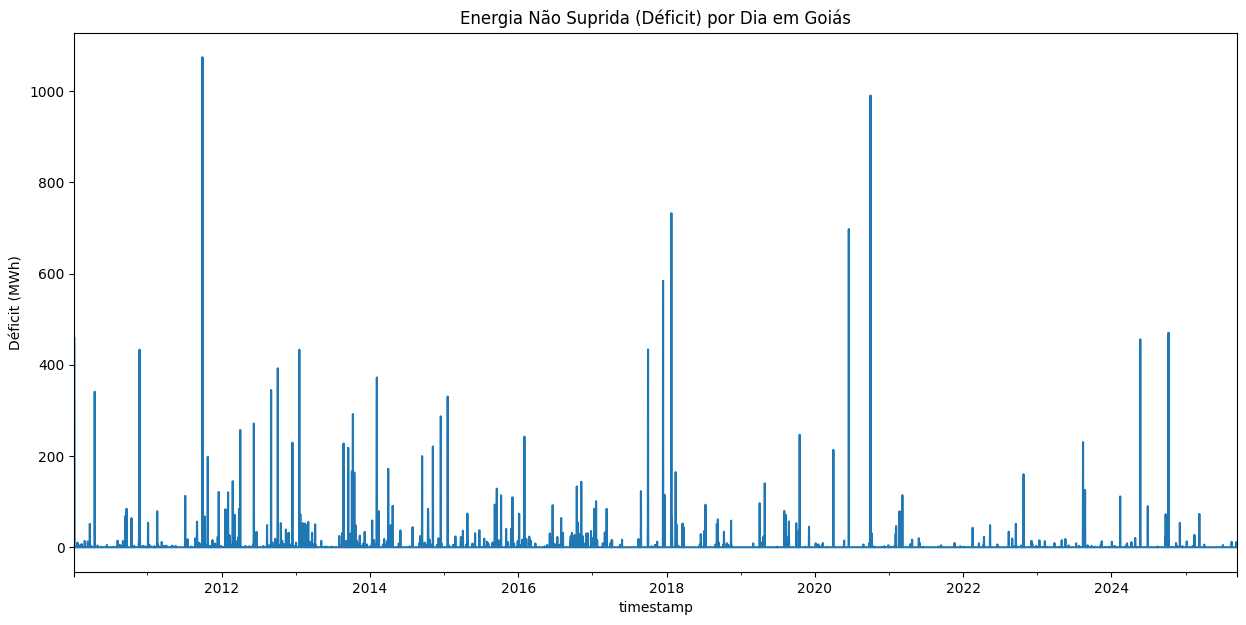

In [7]:
# Verificar a distribuição das classes de risco
print("Distribuição das classes de risco:")
print(df_diario['nivel_risco'].value_counts())

# Plotar os déficits diários para visualizar os eventos
plt.figure(figsize=(15,7))
plt.title('Energia Não Suprida (Déficit) por Dia em Goiás')
df_diario['deficit_diario_mwh'].plot()
plt.ylabel('Déficit (MWh)')
plt.show()

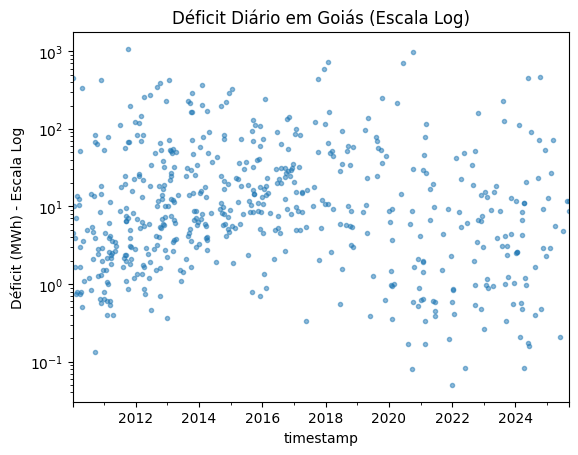

In [8]:
plt.figure()
plt.title('Déficit Diário em Goiás (Escala Log)')
ax = df_diario['deficit_diario_mwh'].plot(logy=True, style='.', alpha=0.5)
ax.set_ylabel("Déficit (MWh) - Escala Log")
plt.show()

In [9]:
output_path = '../data/processed/target_variable_daily.parquet'
df_diario.to_parquet(output_path)
print(f"DataFrame final salvo em: {output_path}")

DataFrame final salvo em: ../data/processed/target_variable_daily.parquet
